# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [1]:
#загрузка данных
import pandas as pd
data_source = pd.read_csv('../Data/orange_small_churn_data.txt')
labels = pd.read_csv('../Data/orange_small_churn_labels.txt', header=None)
data_source['label'] = labels

In [2]:
# произведем преобразование и фильтрацию признаков (на основе прошлых недель)

from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

def preprocess(data_train, filling_method, cat_method='dummy'):
    data = data_train.copy()
    #Отбросим признаки, у которых больше половины значений незаполнены
    bad_features = data.columns[data.isnull().mean(axis=0)>0.5]
    data = data.drop(bad_features, axis=1)
    
    #Рассмотрим отдельно вещественные и категориальные признаки
    all_real_features = ["Var"+str(i) for i in xrange(1, 191)]
    real_features = data.columns[data.columns.isin(all_real_features)]
    cat_features = data.columns[~data.columns.isin(all_real_features+['label'])]
    
    #В вещественных признаках заменим пропуски на средние значения признаков и произведем стандартизацию признаков
    filling_values = filling_method(data[real_features], axis=0)
    data[real_features] = data[real_features].fillna(filling_values)
    sc = StandardScaler()
    data[real_features] = sc.fit_transform(data[real_features])
    
    #В категориальных признаках отбросим те из них, которые имеют слишком много категорий
    num_cat = np.array([np.unique(data[feat]).shape[0] for feat in cat_features])
    bad_cat_features = cat_features[num_cat>100]
    data = data.drop(bad_cat_features, axis=1)
    cat_features = cat_features[~cat_features.isin(bad_cat_features)]
    
    #В категориальных признаках произведем dummy кодирование, при этом пропуск будем расценивать как еще одну категорию
    if cat_method == 'dummy':
        data = pd.get_dummies(data, dummy_na=True, columns = cat_features, drop_first=True)
    elif cat_method == 'le':
        le = LabelEncoder()
        for feat in cat_features:
            data[feat] = le.fit_transform(data[feat])
    
    #добавим еще тройку категориальных признаков, которые (как мы ранее выяснили) имеют высокую корреляция с целевым признаком. Но применим к ним LabelEncoder, поскольку они имеют слишком много категорий
    corr_cat_features = ['Var199', 'Var216', 'Var192']
    le = LabelEncoder()
    for feat in corr_cat_features:
        data_train[feat] = data_train[feat].fillna('NaN')
        data[feat] = le.fit_transform(data_train[feat])
    
    return data

data = preprocess(data_source, pd.DataFrame.mean)

In [3]:
X = data.drop('label', axis = 1)
y = data.label
X.shape

(40000, 388)

In [4]:
#построим кривую обучения
from sklearn.model_selection import learning_curve

train_sizes = np.arange(0.05, 1.05, 0.05)

#в качестве классификатора возьмем LogisticRegression
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedKFold

lr = LogisticRegression()
scorer = make_scorer(average_precision_score, needs_threshold=True)

#сначала оценим качество модели на всей выборке
scores = cross_val_score(lr, X, y, scoring=scorer, cv=StratifiedKFold(y, n_folds=5))
print "PR AUC for logistic regression: {}".format(np.mean(scores))

#построим кривую обучения
t_scores = learning_curve(lr, X, y, train_sizes=train_sizes, scoring=scorer, cv=StratifiedKFold(y, n_folds=5))

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


PR AUC for logistic regression: 0.125507083078


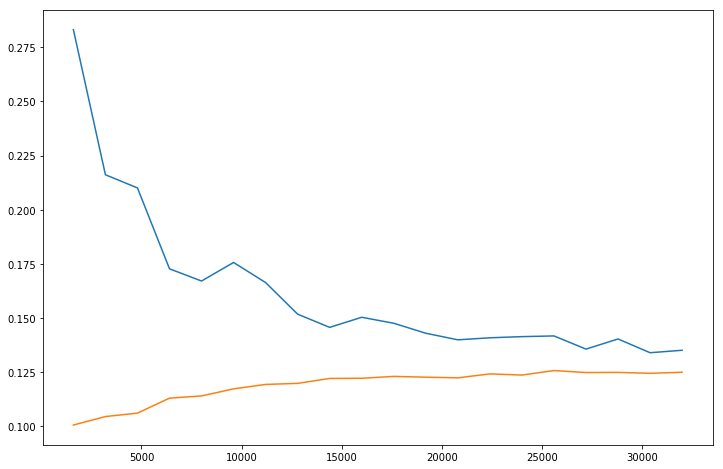

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(t_scores[0], t_scores[1].mean(axis=1))
plt.plot(t_scores[0], t_scores[2].mean(axis=1))

Вывод: по данным кривым нельзя с уверенностью сказать, что можно обучаться по меньшему размеру выборки. Кривые до конца продолжают сближение, а значит будем использовать для обучения всю выборку.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [17]:
counts = y.value_counts()
counts

-1    37024
 1     2976
Name: label, dtype: int64

In [ ]:
# 1 вариант. Добавим увеличивающие веса только для объектов класса 1
sample_weights1 = np.ones(data.shape[0])
sample_weights1[data.label==1] = float(counts[-1])/counts[1]
scores = cross_val_score(lr, X, y, scoring=scorer, cv=StratifiedKFold(y, n_folds=5), fit_params={'sample_weight': sample_weights1})
print "PR AUC for logistic regression with weights #1: {}".format(np.mean(scores))

# 2 вариант. Добавим уменьшающие веса только для объектов класса -1
sample_weights2 = np.ones(data.shape[0])
sample_weights2[data.label==-1] = float(counts[1])/counts[-1]
scores = cross_val_score(lr, X, y, scoring=scorer, cv=StratifiedKFold(y, n_folds=5), fit_params={'sample_weight': sample_weights2})
print "PR AUC for logistic regression with weights #2: {}".format(np.mean(scores))

# 3 вариант. Добавим веса для объектов обоих классов обратно пропрционально их долям в выборке
sample_weights3 = np.ones(data.shape[0])
sample_weights3[data.label==-1] = 1./np.mean(y==-1)
sample_weights3[data.label==1] = 1./np.mean(y==1)
scores = cross_val_score(lr, X, y, scoring=scorer, cv=StratifiedKFold(y, n_folds=5), fit_params={'sample_weight': sample_weights3})
print "PR AUC for logistic regression with weights #3: {}".format(np.mean(scores))

В результате применения весов качество чуть-чуть подросло, 2 вариант выглядит наиболее оптимальным.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [21]:
import numpy as np 
print np.unique(y_enn, return_counts=True)
print np.unique(y_rs, return_counts=True)
print np.unique(y_tl, return_counts=True)

(array([-1,  1], dtype=int64), array([11904,  2976], dtype=int64))
(array([-1,  1], dtype=int64), array([11904,  2976], dtype=int64))
(array([-1,  1], dtype=int64), array([11904,  2976], dtype=int64))


In [20]:
#Попробуем удалить объекты большего класса так, чтобы доля меньшего класса стала хотя бы 20%
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

#1 вариант. Удаляем случайным образом
rs = RandomUnderSampler(random_state=42, ratio={-1: counts[1]*4, 1: counts[1]})
X_rs, y_rs = rs.fit_sample(X, y)
scores = cross_val_score(lr, X_rs, y_rs, scoring=scorer, cv=StratifiedKFold(y_rs, n_folds=5))
print "PR AUC for logistic regression with random under-sampling: {}".format(np.mean(scores))

#2 вариант. Удаляем те объекты, которые не согласуются со своими соседями
nm = NearMiss(ratio={-1: counts[1]*4, 1: counts[1]})
X_nm, y_nm = enn.fit_sample(X, y)
scores = cross_val_score(lr, X_nm, y_nm, scoring=scorer, cv=StratifiedKFold(y_nm, n_folds=5))
print "PR AUC for logistic regression with under-sampling with nearest neighbours: {}".format(np.mean(scores))

#3 вариант. Используем метод TomekLinks. При этом методе удаляются те объекты большего класса, для которых ближашим по расстоянию является объект другого класса
tl = TomekLinks(random_state=42, ratio={-1: counts[1]*4, 1: counts[1]})
X_tl, y_tl = rs.fit_sample(X, y)
scores = cross_val_score(lr, X_tl, y_tl, scoring=scorer, cv=StratifiedKFold(y_tl, n_folds=5))
print "PR AUC for logistic regression with tomek links under-sampling: {}".format(np.mean(scores))

PR AUC for logistic regression with random under-sampling: 0.304379469718
(14880L, 388L)
PR AUC for logistic regression with under-sampling with nearest neighbours: 0.375370447283
PR AUC for logistic regression with tomek links under-sampling: 0.304379469718


3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [22]:
# Ранее мы заполняли пропущенные значения средним, теперь попробуем заполнять медианой и модой, сравним качество с полученным ранее
data_med = preprocess(data_source, pd.DataFrame.median)
X_med = data_med.drop('label', axis = 1)
y_med = data_med.label
scores = cross_val_score(lr, X_med, y_med, scoring=scorer, cv=StratifiedKFold(y_med, n_folds=5))
print "PR AUC for logistic regression with medians: {}".format(np.mean(scores))

data_mod = preprocess(data_source, lambda data, axis: pd.DataFrame.mode(data, axis=axis, numeric_only=True).iloc[0])
X_mod = data_mod.drop('label', axis = 1)
y_mod = data_mod.label
scores = cross_val_score(lr, X_mod, y_mod, scoring=scorer, cv=StratifiedKFold(y_mod, n_folds=5))
print "PR AUC for logistic regression with modes: {}".format(np.mean(scores))

PR AUC for logistic regression with medians: 0.125231604934
PR AUC for logistic regression with modes: 0.125606156456


4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [ ]:
#Ранее мы обрабатывали большинство категориальных признаков (кроме имеющих большое количество категорий) с помощью dummy кодирования.
#Теперь попробуем вместо этого применить к ним LabelEncoder.
data_le = preprocess(data_source, pd.DataFrame.mean, cat_method='le')
X_le = data_le.drop('label', axis = 1)
y_le = data_le.label
scores = cross_val_score(lr, X_le, y_le, scoring=scorer, cv=StratifiedKFold(y_le, n_folds=5))
print "PR AUC for logistic regression with label encoder for all categorical data: {}".format(np.mean(scores))

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [ ]:
from sklearn.feature_selection import 

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [26]:
lr.coef_

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 